In [1]:
# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

#necessary libraries to handle dataframes and numeric data 
import pandas as pd
import numpy as np

# for visuals
import pylab as plt
import seaborn as sns
%matplotlib inline

# for data splitting into train and test
from sklearn.model_selection import train_test_split as tts

#the model
from sklearn.linear_model import LogisticRegression

#the metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import recall_score 
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score

# to standardize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

#for hyperparameter tuning
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.metrics import make_scorer 
from sklearn.model_selection import cross_val_score

#to save the model
import pickle

# to get the most important columns
import statsmodels.api as sm
from sklearn.inspection import permutation_importance

## Preprocessing 1: 

Downsampling, standardScaler to standardize the data, with repeat retailer column, without removing outliers. 

In [2]:
data=pd.read_csv('../../data/data_pp1.csv')

In [3]:
data.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,2.131956,56.372401,6.358667,1.0,0.0,0.0,1.0,1.0
1,3.803057,67.241081,1.872950,1.0,0.0,0.0,1.0,1.0
2,15.694986,175.989182,0.855623,1.0,0.0,0.0,1.0,1.0
3,26.711462,1.552008,4.603601,1.0,1.0,0.0,1.0,1.0
4,10.664474,1.565769,4.886521,1.0,0.0,0.0,1.0,1.0


In [4]:
X=data.drop('fraud', axis=1)
y=data['fraud']

Dividing into X (df without my target column) and y(my target column)

In [5]:
X_train, X_test, y_train, y_test =tts(X, y, 
                                       random_state=42,
                                       stratify=y)


Splitting my data into train and test

In [6]:
escalador = StandardScaler()   
 
escalador.fit(X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
 
X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = escalador.transform(X_train[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])   
X_test[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = escalador.transform(X_test[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])  


Standardizing my data using standardscaler

Standardizing the numeric columns 'distance_from_home', 'distance_from_last_transaction' and 'ration_to_median_purchase_price' since they have different scales . Data needs to be more or less on the same scale so that the model doesn´t give preference to one column over the other due to the scale being higher. Please note I fitted the train dataset and transformed both train and test with that information. You can read more about that in the below article
https://sebastianraschka.com/faq/docs/scale-training-test.html

In [7]:
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
34364,-0.407100,-0.197373,0.337115,1.0,0.0,0.0,1.0
21079,-0.309508,-0.131652,1.266614,1.0,0.0,0.0,1.0
100073,-0.353875,-0.106955,-0.472580,1.0,0.0,0.0,0.0
5769,-0.370031,-0.211139,0.479994,1.0,0.0,0.0,1.0
57842,-0.424345,-0.139255,0.617343,0.0,0.0,0.0,0.0


In [8]:
X_test.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
116281,-0.268551,-0.192260,0.124602,1.0,0.0,1.0,1.0
61152,-0.389862,-0.209752,1.180487,1.0,0.0,0.0,1.0
105136,-0.099497,-0.190219,-0.198441,1.0,0.0,1.0,1.0
161774,-0.364760,5.560881,-0.355935,1.0,0.0,1.0,1.0
154787,-0.428819,-0.033384,-0.630839,0.0,1.0,0.0,0.0


This is how train and test look like now 

In [9]:
lr=LogisticRegression()

Initiated the model

In [10]:
lr.fit(X_train, y_train)

LogisticRegression()

Trained the model

In [11]:
y_test_pred_lr = lr.predict(X_test)

In [12]:
y_train_pred_lr = lr.predict(X_train)

Making predictions for both test and train data 

In [13]:
#Getting the metrics for each model for train and test 

def metrics(y_test, y_test_pred_model, y_train, y_train_pred_model, model):
    
    accuracy_test = accuracy_score(y_test, y_test_pred_model)
    precision_test = precision_score(y_test, y_test_pred_model)
    recall_test = recall_score(y_test, y_test_pred_model)
    f1_test = f1_score(y_test, y_test_pred_model)
    kappa_test = cohen_kappa_score(y_test, y_test_pred_model)

    accuracy_train = accuracy_score(y_train, y_train_pred_model)
    precision_train = precision_score(y_train, y_train_pred_model)
    recall_train = recall_score(y_train, y_train_pred_model)
    f1_train = f1_score(y_train, y_train_pred_model)
    kappa_train = cohen_kappa_score(y_train, y_train_pred_model)

    
    df = pd.DataFrame({'accuracy': [accuracy_test, accuracy_train], 
                       'precision': [precision_test, precision_train],
                       'recall': [recall_test, recall_train], 
                       'f1': [f1_test, f1_train],
                       'kapppa': [kappa_test, kappa_train],
                       'set': ['test', 'train' ]})
    
    df['model'] = model
    return df


In [14]:
results_logistic = metrics(y_test, y_test_pred_lr, y_train, y_train_pred_lr, 'Logistic Regression pp1')

Getting the metrics

In [15]:
results_logistic

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941788,0.935176,0.949384,0.942226,0.883575,test,Logistic Regression pp1
1,0.940429,0.932849,0.949185,0.940946,0.880858,train,Logistic Regression pp1


As per the metrics above the model is working quite well. It is not overfitted since the metrics for train are not higher than the metrics for test. There is room for improvement however

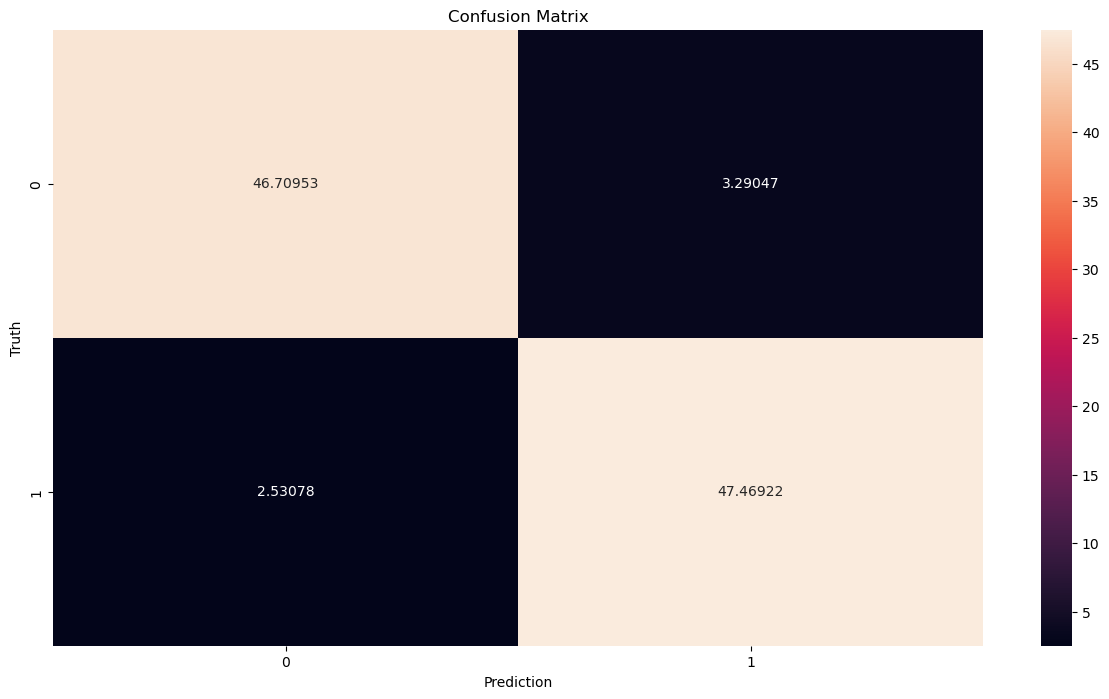

In [16]:
#confusion matrix for Logistic Regression
plt.figure(figsize=(15, 8))

conf_matrix = cm(y_test, y_test_pred_lr)

# Added 5 decimal places so I can compare to the tuned model later
percentage_matrix = conf_matrix / conf_matrix.sum() * 100
percentage_matrix_formatted = ["{:.5f}".format(value) for value in percentage_matrix.flatten()]

percentage_matrix_formatted = np.array(percentage_matrix_formatted).reshape(percentage_matrix.shape)

ax = sns.heatmap(percentage_matrix, annot=percentage_matrix_formatted, fmt='')

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show()


From the confusion matrix above we can see that logistic regression model has 47% True Negatives (Predicted not fraud when it is actually not fraud),  47% True Positive (Predicted fraud that is actually fraud), 2.5% False Negatives (Predicted no fraud when there was fraud) and 3.3% False Positives (Predicted fraud when there was no fraud) 

In [17]:
conf_matrix_pp1 = cm(y_test, y_test_pred_lr)

# Convert confusion matrix to DataFrame
conf_matrix_pp1_df = pd.DataFrame(conf_matrix_pp1, columns=['Predicted no fraud', 'Predicted fraud'], index=['Actual no fraud', 'Actual fraud'])

In [18]:
conf_matrix_pp1_df

,Predicted no fraud,Predicted fraud
Actual no fraud,20413,1438
Actual fraud,1106,20745


In [19]:
conf_matrix_pp1_df = pd.DataFrame({
    'model': ['Logistic Regression pp1', 'Logistic Regression pp1', 'Logistic Regression pp1', 'Logistic Regression pp1'],
    'pred_actual': ['predicted no fraud', 'predicted no fraud', 'predicted fraud', 'predicted fraud'],
    'actual': ['actual no fraud', 'actual fraud', 'actual no fraud', 'actual fraud'],
    'predvsactual':['TN', 'FN', 'FP', 'TP'],
    'count': [20413, 1106, 1438, 20745]
})

In [20]:
conf_matrix_pp1_df

,model,pred_actual,actual,predvsactual,count
0,Logistic Regression pp1,predicted no fraud,actual no fraud,TN,20413
1,Logistic Regression pp1,predicted no fraud,actual fraud,FN,1106
2,Logistic Regression pp1,predicted fraud,actual no fraud,FP,1438
3,Logistic Regression pp1,predicted fraud,actual fraud,TP,20745


In [21]:
conf_matrix_pp1_df.to_csv('../../data/confmatrpp1.csv', index=False)

distance_from_home: 0.10317986972373501
distance_from_last_transaction: 0.0341952313395268
ratio_to_median_purchase_price: 0.3043827132244139
repeat_retailer: 0.004790779979558539
used_chip: 0.010166582765090856
used_pin_number: 0.027390813540188862
online_order: 0.07377618110536514


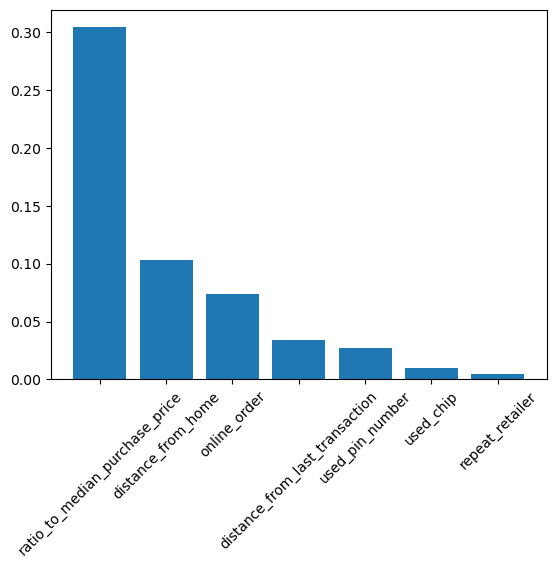

In [22]:
# Calculate permutation feature importance
perm_importancepp1 = permutation_importance(lr, X_test, y_test, n_repeats=30, random_state=42)

for feature, importance in zip(X.columns, perm_importancepp1.importances_mean):
    print(f"{feature}: {importance}")

sorted_idx = perm_importancepp1.importances_mean.argsort()[::-1]
plt.bar(range(X.shape[1]), perm_importancepp1.importances_mean[sorted_idx])
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=45)
plt.show()


In [23]:
feature_importancepp1 = pd.DataFrame({'Model': 'Logistic Regression pp1',
    'Feature': X.columns,
    'Importance': perm_importancepp1.importances_mean})
feature_importancepp1

,Model,Feature,Importance
0,Logistic Regression pp1,distance_from_home,0.103180
1,Logistic Regression pp1,distance_from_last_transaction,0.034195
2,Logistic Regression pp1,ratio_to_median_purchase_price,0.304383
3,Logistic Regression pp1,repeat_retailer,0.004791
4,Logistic Regression pp1,used_chip,0.010167
5,Logistic Regression pp1,used_pin_number,0.027391
6,Logistic Regression pp1,online_order,0.073776


In [24]:
feature_importancepp1.to_csv('../../data/feature_importance_pp1.csv', index=False)  #saving feature importance

## Hyper Parameter Tuning
Iterating with different hyperparameters for the logistic regression model , to see if I can improve the recall score. I will use hyperopt for that. 

In [25]:
#I want to improve the recall_score in the logistic regression model
recall_scorer = make_scorer(recall_score, greater_is_better=True)

space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -5, 5),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'random_state': hp.choice('random_state', [None, 42]),
    'solver': hp.choice('solver', ['liblinear'])
}

def objective(space):
    model = LogisticRegression(
        penalty=space['penalty'],
        C=space['C'],
        class_weight=space['class_weight'],
        random_state=space['random_state'],
        solver=space['solver'],
    )
    
    cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring=recall_scorer).mean()
    
    return {'loss': -cv_recall, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective,  
            space=space,    
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best hyperparameters:", best)


100%|█████████████████████████████████████████████| 100/100 [07:15<00:00,  4.36s/trial, best loss: -0.9505125728967606]
Best hyperparameters: {'C': 0.008643582481655324, 'class_weight': 0, 'penalty': 0, 'random_state': 0, 'solver': 0}


In [26]:
#Creating a  model for logistic regression with the best parameters found by hyperopt in the above cell. 
class_weight_map = {0: None, 1: 'balanced'}
best_class_weight = class_weight_map[best['class_weight']]
penalty_map = {0: 'l1', 1: 'l2'}
best_penalty = penalty_map[best['penalty']]
solver_map = {0: 'liblinear'}
best_solver = solver_map[best['solver']]

model = LogisticRegression(
    C=best['C'],
    class_weight=best_class_weight,
    penalty=best_penalty,
    random_state=best['random_state'],
    solver=best_solver,
)


In [27]:
model.fit(X_train, y_train)   #training the model

LogisticRegression(C=0.008643582481655324, penalty='l1', random_state=0,
                   solver='liblinear')

In [28]:
#getting the predictions
y_pred_model_test = model.predict(X_test)
y_pred_model_train = model.predict(X_train)  

In [29]:
#calling the function metrics made above to get all the metrics for this newly created model 
results_model = metrics(y_test, y_pred_model_test, y_train, y_pred_model_train, 'Logistic Regression after tuning pp1')
results_model

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941810,0.934005,0.950803,0.942329,0.883621,test,Logistic Regression after tuning pp1
1,0.940429,0.931851,0.950360,0.941015,0.880858,train,Logistic Regression after tuning pp1


In [30]:
# Concatenating the initial logistic regression model and the tuned logistic regression model so we can compare them 
results_pp1=pd.concat([results_logistic, results_model], axis=0)

In [31]:
results_pp1

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941788,0.935176,0.949384,0.942226,0.883575,test,Logistic Regression pp1
1,0.940429,0.932849,0.949185,0.940946,0.880858,train,Logistic Regression pp1
0,0.941810,0.934005,0.950803,0.942329,0.883621,test,Logistic Regression after tuning pp1
1,0.940429,0.931851,0.950360,0.941015,0.880858,train,Logistic Regression after tuning pp1


As we can see from the data above, there is some improvement in the recall score.

In [32]:
results_pp1.to_csv('../../data/model_metrics_pp1.csv')

Saving to csv file

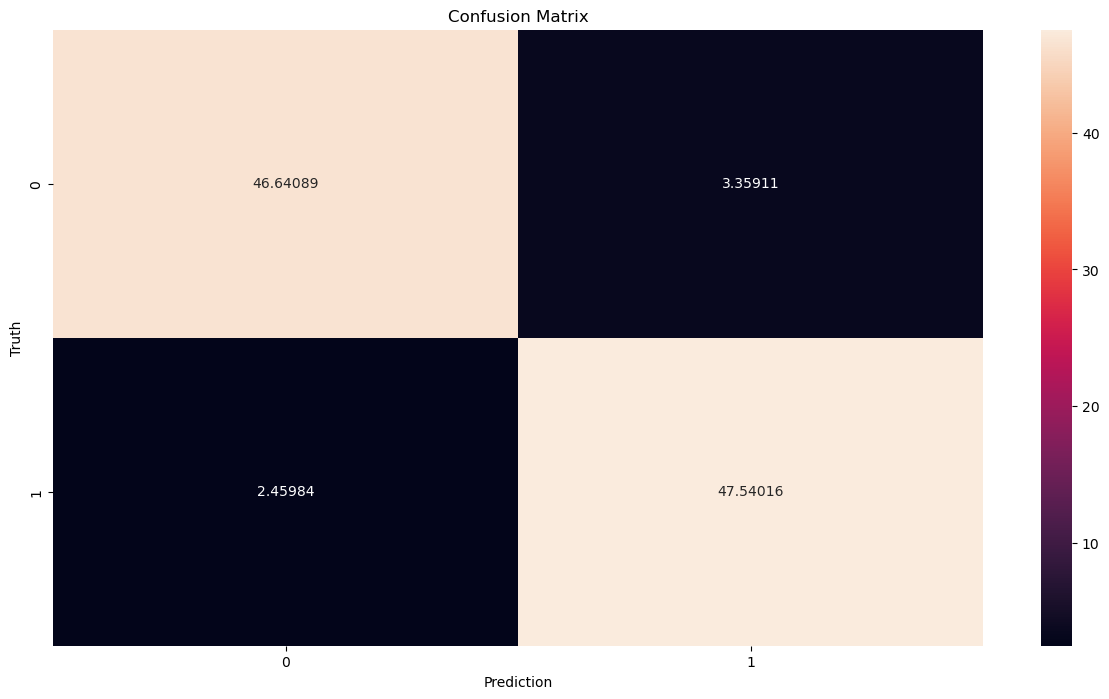

In [33]:
#confusion matrix for Tuned logistic regression. 
plt.figure(figsize=(15, 8))

conf_matrix = cm(y_test, y_pred_model_test)

percentage_matrix = conf_matrix / conf_matrix.sum() * 100

#I added 5 decimal places so we can see the difference from the default logistic regression model
percentage_matrix_formatted = ["{:.5f}".format(value) for value in percentage_matrix.flatten()]

percentage_matrix_formatted = np.array(percentage_matrix_formatted).reshape(percentage_matrix.shape)

ax = sns.heatmap(percentage_matrix, annot=percentage_matrix_formatted, fmt='')

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show()


The confusion matrix has changed a bit. The False Positives (which are the ones I prefer for this project) have increased and the False Negatives (the ones I wanted to decrease) have decreased. There is some improvement therefore but it is small. 

In [34]:
conf_matrix = cm(y_test, y_pred_model_test)

# Convert confusion matrix to DataFrame
conf_matrix_pp1_tuned_df = pd.DataFrame(conf_matrix, columns=['Predicted no fraud', 'Predicted fraud'], index=['Actual no fraud', 'Actual fraud'])

In [35]:
conf_matrix_pp1_tuned_df

,Predicted no fraud,Predicted fraud
Actual no fraud,20383,1468
Actual fraud,1075,20776


In [36]:
conf_matrix_pp1_tuned_df = pd.DataFrame({
    'model': ['Logistic Regression after tuning pp1', 'Logistic Regression after tuning pp1', 'Logistic Regression after tuning pp1', 'Logistic Regression after tuning pp1'],
    'prediction': ['predicted no fraud', 'predicted no fraud', 'predicted fraud', 'predicted fraud'],
    'actual': ['actual no fraud', 'actual fraud', 'actual no fraud', 'actual fraud'],
    'predvsactual':['TN', 'FN', 'FP', 'TP'],
    'count': [20383, 1079, 1468, 20772]
})


In [37]:
conf_matrix_pp1_tuned_df

,model,prediction,actual,predvsactual,count
0,Logistic Regression after tuning pp1,predicted no fraud,actual no fraud,TN,20383
1,Logistic Regression after tuning pp1,predicted no fraud,actual fraud,FN,1079
2,Logistic Regression after tuning pp1,predicted fraud,actual no fraud,FP,1468
3,Logistic Regression after tuning pp1,predicted fraud,actual fraud,TP,20772


In [38]:
conf_matrix_pp1_tuned_df.to_csv('../../data/confmatrpp1tuned.csv', index=False) #saving the conf matrix

In [39]:
pickle.dump(lr, open('models/logistic_regression_pp1_default.pk', 'wb'))  
pickle.dump(model, open('models/logistic_regression_pp1_tuned.pk', 'wb'))   

Saving the models

Getting the information needed for a power bi dashboard

distance_from_home: 0.10321724406205662
distance_from_last_transaction: 0.03382072521471172
ratio_to_median_purchase_price: 0.3079149695666102
repeat_retailer: 0.004428477720317877
used_chip: 0.010148276966729182
used_pin_number: 0.02527725657101883
online_order: 0.07145744664622518


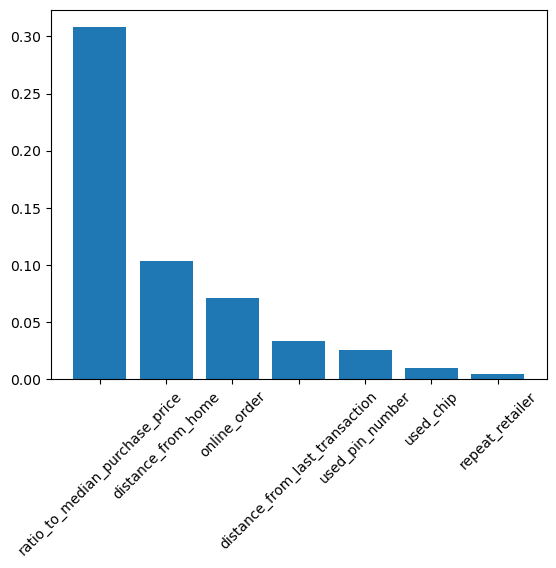

In [40]:
# Calculate permutation feature importance (importance of the columns)
perm_importancepp1tuned = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

for feature, importance in zip(X.columns, perm_importancepp1tuned.importances_mean):
    print(f"{feature}: {importance}")

sorted_idx = perm_importancepp1tuned.importances_mean.argsort()[::-1]
plt.bar(range(X.shape[1]), perm_importancepp1tuned.importances_mean[sorted_idx])
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=45)
plt.show()


In [41]:
feature_importancepp1tuned = pd.DataFrame({'Model': 'Logistic Regression after tuning pp1',
    'Feature': X.columns,
    'Importance': perm_importancepp1tuned.importances_mean})
feature_importancepp1tuned

,Model,Feature,Importance
0,Logistic Regression after tuning pp1,distance_from_home,0.103217
1,Logistic Regression after tuning pp1,distance_from_last_transaction,0.033821
2,Logistic Regression after tuning pp1,ratio_to_median_purchase_price,0.307915
3,Logistic Regression after tuning pp1,repeat_retailer,0.004428
4,Logistic Regression after tuning pp1,used_chip,0.010148
5,Logistic Regression after tuning pp1,used_pin_number,0.025277
6,Logistic Regression after tuning pp1,online_order,0.071457


In [42]:
feature_importancepp1tuned.to_csv('../../data/feature_importancepp1tuned.csv', index=False)

Saving to csv file

## Preprocessing 2:
Upsampling, max-min to standardize the data, without repeat retailer column, outliers removed. 

In [43]:
data_pp2=pd.read_csv('../../data/data_pp2.csv')

In [44]:
data_pp2.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,0.0,1.0,0.0


In [45]:
X_pp2=data_pp2.drop('fraud', axis=1)
y_pp2=data_pp2['fraud']

Dividing into X (df without my target column) and y(my target column)

In [46]:
X_train2, X_test2, y_train2, y_test2 =tts(X_pp2, y_pp2, 
                                       random_state=42,
                                       stratify=y_pp2)


Splitting my data into train and test

In [47]:
scaler = MinMaxScaler()
 
scaler.fit(X_train2[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
 
X_train2[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = scaler.transform(X_train2[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])   
X_test2[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = scaler.transform(X_test2[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])  


Standardizing my data using MinMaxScaler

In [48]:
X_train2.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,used_chip,used_pin_number,online_order
740823,0.152006,0.165432,0.997607,1.0,0.0,1.0
1027318,0.053624,0.331380,0.927654,0.0,0.0,1.0
570198,0.006793,0.170880,0.519988,0.0,0.0,1.0
1060821,0.251114,0.017425,0.885811,1.0,0.0,1.0
780157,0.621325,0.437289,0.942692,0.0,0.0,1.0


In [49]:
lr_pp2=LogisticRegression()

Initiating the model

In [50]:
lr_pp2.fit(X_train2, y_train2)

LogisticRegression()

Fitting the model

In [51]:
y_test2_pred_lr = lr_pp2.predict(X_test2)

In [52]:
y_train2_pred_lr = lr_pp2.predict(X_train2)

Making predictions

In [53]:
results_pp2 = metrics(y_test2, y_test2_pred_lr, y_train2, y_train2_pred_lr, 'Logistic Regression pp2')

Calculating the metrics

In [54]:
results_pp2

,accuracy,precision,recall,f1,kapppa,set,model
0,0.992803,0.988442,0.997266,0.992835,0.985605,test,Logistic Regression pp2
1,0.993088,0.988760,0.997516,0.993119,0.986177,train,Logistic Regression pp2


In [55]:
results_pp2.to_csv('../../data/model_metrics_pp2.csv', index=False)

Saving the file

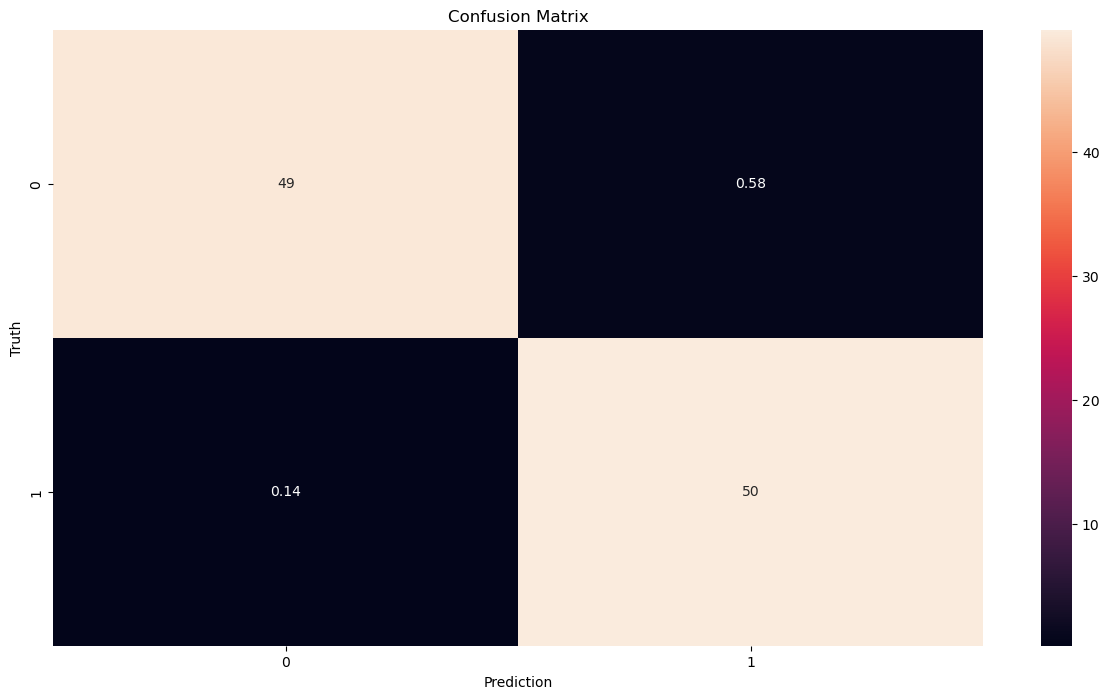

In [56]:
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test2, y_test2_pred_lr)/cm(y_test2, y_test2_pred_lr).sum() * 100, 
               annot=True)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();


From the confusion matrix above we can see that this model has 49% True Negatives (Predicted not fraud when it is actually not fraud),  50% True Positive (Predicted fraud that is actually fraud), 0.14% False Negatives (Predicted no fraud when there was fraud) and 0.58% False Positives (Predicted fraud when there was no fraud) 

In [57]:
conf_matrix_pp2 = cm(y_test2, y_test2_pred_lr)

# Convert confusion matrix to DataFrame
conf_matrix_pp2_df = pd.DataFrame(conf_matrix_pp2, columns=['Predicted no fraud', 'Predicted fraud'], index=['Actual no fraud', 'Actual fraud'])

In [58]:
conf_matrix_pp2_df

,Predicted no fraud,Predicted fraud
Actual no fraud,175359,2069
Actual fraud,485,176942


In [59]:
conf_matrix_pp2_df = pd.DataFrame({
    'model': ['Logistic Regression pp2', 'Logistic Regression pp2', 'Logistic Regression pp2', 'Logistic Regression pp2'],
    'prediction': ['predicted no fraud', 'predicted no fraud', 'predicted fraud', 'predicted fraud'],
    'actual': ['actual no fraud', 'actual fraud', 'actual no fraud', 'actual fraud'],
    'predvsactual':['TN', 'FN', 'FP', 'TP'],
    'count': [175359, 485, 2069, 176942]
})

In [60]:
conf_matrix_pp2_df

,model,prediction,actual,predvsactual,count
0,Logistic Regression pp2,predicted no fraud,actual no fraud,TN,175359
1,Logistic Regression pp2,predicted no fraud,actual fraud,FN,485
2,Logistic Regression pp2,predicted fraud,actual no fraud,FP,2069
3,Logistic Regression pp2,predicted fraud,actual fraud,TP,176942


In [61]:
conf_matrix_pp2_df.to_csv('../../data/confmatrpp2.csv', index=False)

distance_from_home: 0.0010460610671963984
distance_from_last_transaction: -2.338983528488899e-05
ratio_to_median_purchase_price: 0.4542462883900936
used_chip: 0.0009567288047230023
used_pin_number: 0.026376031524613288
online_order: 0.014523209010252969


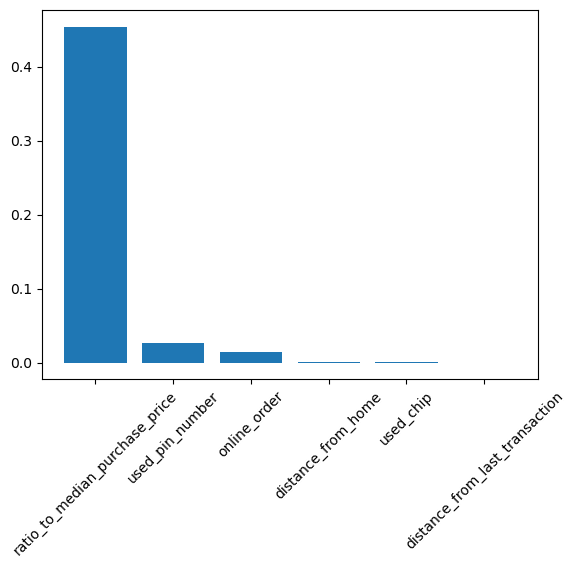

In [62]:
# Calculate permutation feature importance
perm_importancepp2 = permutation_importance(lr_pp2, X_test2, y_test2, n_repeats=30, random_state=42)

for feature, importance in zip(X_pp2.columns, perm_importancepp2.importances_mean):
    print(f"{feature}: {importance}")

sorted_idx = perm_importancepp2.importances_mean.argsort()[::-1]
plt.bar(range(X_pp2.shape[1]), perm_importancepp2.importances_mean[sorted_idx])
plt.xticks(range(X_pp2.shape[1]), X_pp2.columns[sorted_idx], rotation=45)
plt.show()


In [63]:
feature_importancepp2 = pd.DataFrame({'Model': 'Logistic Regression pp2',
    'Feature': X_pp2.columns,
    'Importance': perm_importancepp2.importances_mean})
feature_importancepp2

,Model,Feature,Importance
0,Logistic Regression pp2,distance_from_home,0.001046
1,Logistic Regression pp2,distance_from_last_transaction,-0.000023
2,Logistic Regression pp2,ratio_to_median_purchase_price,0.454246
3,Logistic Regression pp2,used_chip,0.000957
4,Logistic Regression pp2,used_pin_number,0.026376
5,Logistic Regression pp2,online_order,0.014523


These are the columns and their importance for this model

In [64]:
feature_importancepp2.to_csv('../../data/feature_importancepp2.csv', index=False)

Saving feature_importancepp2 to csv

In [65]:
pickle.dump(lr_pp2, open('models/logistic_regression_pp2_default.pk', 'wb'))  

Saving the model from pp2

## Preprocessing 3:
Upsampling, robustscaling to standardize the data, with repeat retailer column, with outliers. 

In [66]:
data_pp3=pd.read_csv('../../data/data_pp3.csv')

In [67]:
data_pp3.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [68]:
X_pp3=data_pp3.drop('fraud', axis=1)
y_pp3=data_pp3['fraud']

Dividing into X (all columns except target column) and y(target column)

In [69]:
X_train3, X_test3, y_train3, y_test3 =tts(X_pp3, y_pp3, 
                                       random_state=42,
                                       stratify=y_pp3)


Splitting data into train and test

In [70]:
transformer = RobustScaler()   
 
transformer.fit(X_train3[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])
 
X_train3[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = transformer.transform(X_train3[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])   
X_test3[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']] = transformer.transform(X_test3[['distance_from_home', 'distance_from_last_transaction', 'ratio_to_median_purchase_price']])  


Standardizing the data using RobustScaler (uses median instead of mean and uses IQR instead of standard deviation. This makes it more robust to outliers)

In [71]:
X_train3.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
841874,0.091768,1.186881,0.236953,1.0,0.0,0.0,1.0
409207,-0.151692,0.013433,-0.405160,1.0,1.0,0.0,1.0
624630,1.843131,-0.105719,-0.063244,1.0,0.0,0.0,1.0
144615,0.288234,-0.092269,-0.043419,1.0,1.0,0.0,0.0
1722519,-0.322826,-0.010673,1.225291,0.0,0.0,0.0,1.0


In [72]:
lr_pp3=LogisticRegression()

Initiating the model

In [73]:
lr_pp3.fit(X_train3, y_train3)

LogisticRegression()

Fitting the model

In [74]:
y_test3_pred_lr = lr_pp3.predict(X_test3)

In [75]:
y_train3_pred_lr = lr_pp3.predict(X_train3)

Making predictions

In [76]:
results_pp3 = metrics(y_test3, y_test3_pred_lr, y_train3, y_train3_pred_lr, 'Logistic Regression pp3')

Getting the metrics

In [77]:
results_pp3

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941747,0.934455,0.950138,0.942231,0.883493,test,Logistic Regression pp3
1,0.940871,0.933576,0.949283,0.941364,0.881741,train,Logistic Regression pp3


This model works fairly well, but it could be improved. 

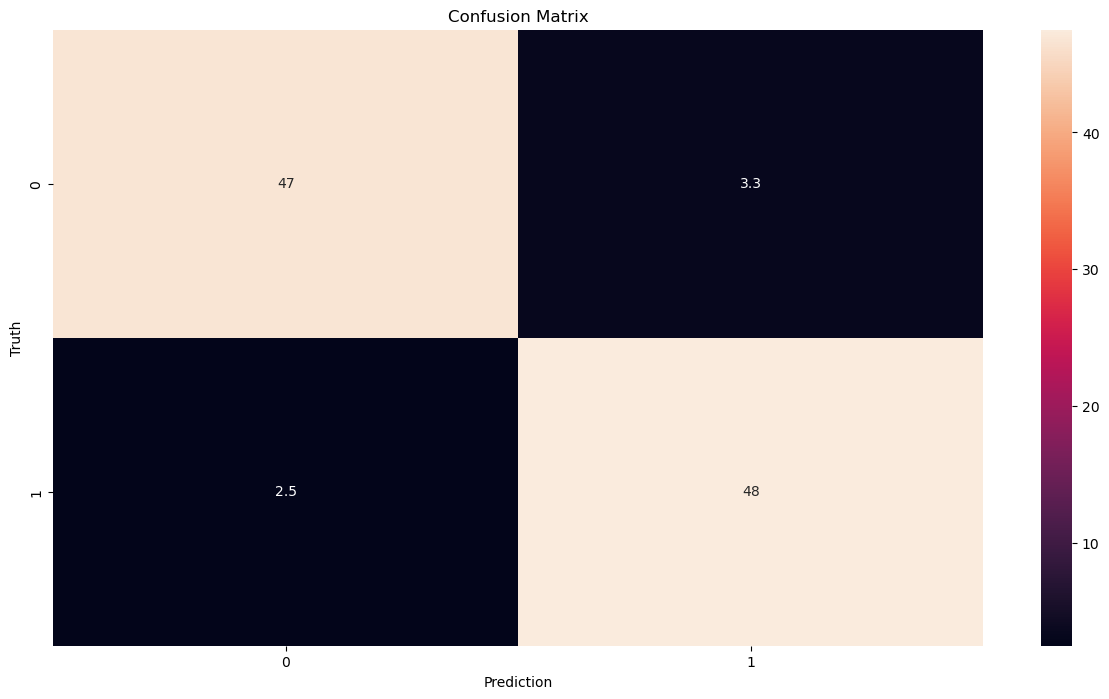

In [78]:
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test3, y_test3_pred_lr)/cm(y_test3, y_test3_pred_lr).sum() * 100, 
               annot=True)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();


From the confusion matrix above we can see that this model has 47% True Negatives (Predicted not fraud when it is actually not fraud),  48% True Positive (Predicted fraud that is actually fraud), 2.5% False Negatives (Predicted no fraud when there was fraud) and 3.3% False Positives (Predicted fraud when there was no fraud) 

In [79]:
conf_matrix_pp3 = cm(y_test3, y_test3_pred_lr)

# Convert confusion matrix to DataFrame
conf_matrix_pp3_df = pd.DataFrame(conf_matrix_pp3, columns=['Predicted no fraud', 'Predicted fraud'], index=['Actual no fraud', 'Actual fraud'])
conf_matrix_pp3_df

,Predicted no fraud,Predicted fraud
Actual no fraud,212945,15205
Actual fraud,11376,216773


In [80]:
conf_matrix_pp3_df = pd.DataFrame({
    'model': ['Logistic Regression pp3', 'Logistic Regression pp3', 'Logistic Regression pp3', 'Logistic Regression pp3'],
    'prediction': ['predicted no fraud', 'predicted no fraud', 'predicted fraud', 'predicted fraud'],
    'actual': ['actual no fraud', 'actual fraud', 'actual no fraud', 'actual fraud'],
    'predvsactual':['TN', 'FN', 'FP', 'TP'],
    'count': [212945, 11376, 15205, 216773]
})

In [81]:
conf_matrix_pp3_df

,model,prediction,actual,predvsactual,count
0,Logistic Regression pp3,predicted no fraud,actual no fraud,TN,212945
1,Logistic Regression pp3,predicted no fraud,actual fraud,FN,11376
2,Logistic Regression pp3,predicted fraud,actual no fraud,FP,15205
3,Logistic Regression pp3,predicted fraud,actual fraud,TP,216773


In [82]:
conf_matrix_pp3_df.to_csv('../../data/confmatrpp3.csv', index=False)

distance_from_home: 0.10251888929554237
distance_from_last_transaction: 0.03370370451538724
ratio_to_median_purchase_price: 0.30501067647894625
repeat_retailer: 0.0037281110266148888
used_chip: 0.010227504333781164
used_pin_number: 0.027648537472140005
online_order: 0.07197919200641105


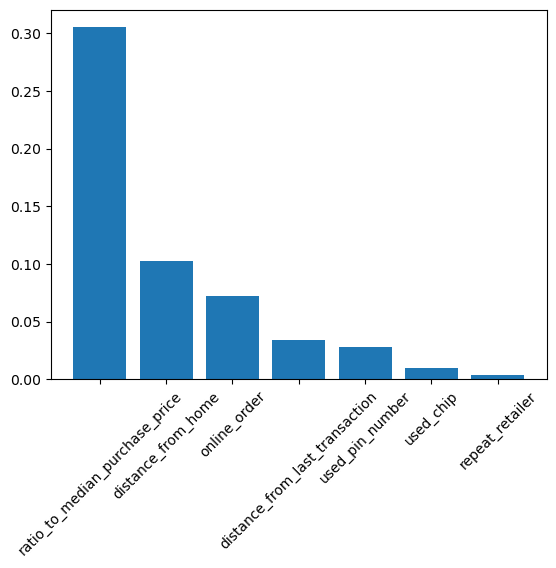

In [83]:
# Calculate permutation feature importance
perm_importancepp3 = permutation_importance(lr_pp3, X_test3, y_test3, n_repeats=30, random_state=42)

for feature, importance in zip(X_pp3.columns, perm_importancepp3.importances_mean):
    print(f"{feature}: {importance}")

sorted_idx = perm_importancepp3.importances_mean.argsort()[::-1]
plt.bar(range(X_pp3.shape[1]), perm_importancepp3.importances_mean[sorted_idx])
plt.xticks(range(X_pp3.shape[1]), X_pp3.columns[sorted_idx], rotation=45)
plt.show()


In [84]:
feature_importancepp3 = pd.DataFrame({'Model': 'Logistic Regression pp3',
    'Feature': X_pp3.columns,
    'Importance': perm_importancepp3.importances_mean})
feature_importancepp3

,Model,Feature,Importance
0,Logistic Regression pp3,distance_from_home,0.102519
1,Logistic Regression pp3,distance_from_last_transaction,0.033704
2,Logistic Regression pp3,ratio_to_median_purchase_price,0.305011
3,Logistic Regression pp3,repeat_retailer,0.003728
4,Logistic Regression pp3,used_chip,0.010228
5,Logistic Regression pp3,used_pin_number,0.027649
6,Logistic Regression pp3,online_order,0.071979


In [85]:
feature_importancepp3.to_csv('../../data/feature_importancepp3.csv', index=False)

In [86]:
#I want to improve the recall_score in the logistic regression model
recall_scorer = make_scorer(recall_score, greater_is_better=True)

space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.loguniform('C', -5, 5),
    'class_weight': hp.choice('class_weight', [None, 'balanced']),
    'random_state': hp.choice('random_state', [None, 42]),
    'solver': hp.choice('solver', ['liblinear'])
}

def objectivepp3(space):
    model = LogisticRegression(
        penalty=space['penalty'],
        C=space['C'],
        class_weight=space['class_weight'],
        random_state=space['random_state'],
        solver=space['solver'],
    )
    
    cv_recall = cross_val_score(model, X_train3, y_train3, cv=5, scoring=recall_scorer).mean()
    
    return {'loss': -cv_recall, 'status': STATUS_OK}

trials = Trials()
best = fmin(fn=objective,  
            space=space,    
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print("Best hyperparameters:", best)


100%|█████████████████████████████████████████████| 100/100 [08:10<00:00,  4.91s/trial, best loss: -0.9504973127123619]
Best hyperparameters: {'C': 0.006770447618298785, 'class_weight': 1, 'penalty': 0, 'random_state': 0, 'solver': 0}


In [87]:
#Creating a  model for logistic regression with the best parameters found by hyperopt in the above cell. 
class_weight_map = {0: None, 1: 'balanced'}
best_class_weight = class_weight_map[best['class_weight']]
penalty_map = {0: 'l1', 1: 'l2'}
best_penalty = penalty_map[best['penalty']]
solver_map = {0: 'liblinear'}
best_solver = solver_map[best['solver']]

model_pp3 = LogisticRegression(
    C=best['C'],
    class_weight=best_class_weight,
    penalty=best_penalty,
    random_state=best['random_state'],
    solver=best_solver,
)


In [88]:
model_pp3.fit(X_train3, y_train3)

LogisticRegression(C=0.006770447618298785, class_weight='balanced',
                   penalty='l1', random_state=0, solver='liblinear')

Fitting the new model

In [89]:
y_test3_pred_lrtuned = model_pp3.predict(X_test3)

In [90]:
y_train3_pred_lrtuned = model_pp3.predict(X_train3)

Making the predictions for the new model

In [91]:
results_model_pp3 = metrics(y_test3, y_test3_pred_lrtuned, y_train3, y_train3_pred_lrtuned, 'Logistic Regression after tuning pp3')
results_pp3=pd.concat([results_pp3, results_model_pp3], axis=0)

Getting the metrics and adding them to the dataframe with pp3 models

In [92]:
results_pp3

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941747,0.934455,0.950138,0.942231,0.883493,test,Logistic Regression pp3
1,0.940871,0.933576,0.949283,0.941364,0.881741,train,Logistic Regression pp3
0,0.941804,0.934339,0.950396,0.942299,0.883607,test,Logistic Regression after tuning pp3
1,0.940876,0.933436,0.949459,0.941379,0.881751,train,Logistic Regression after tuning pp3


In [93]:
results_pp3.to_csv('../../data/model_metrics_pp3.csv', index=False)

Saving the metrics for pp3 models

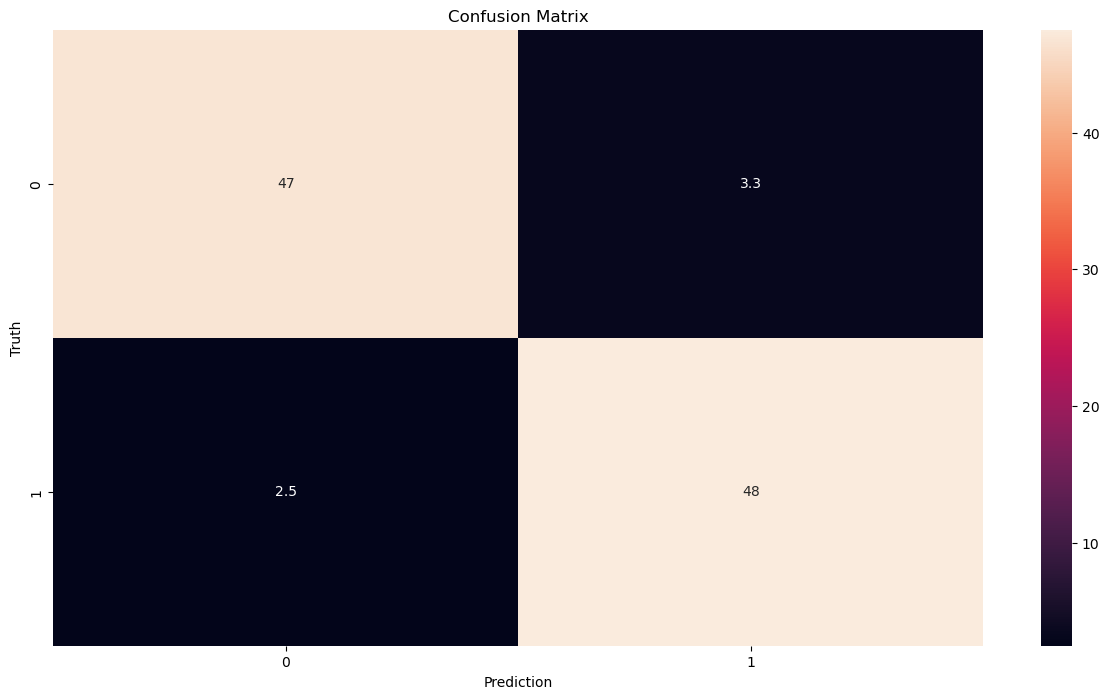

In [94]:
plt.figure(figsize=(15, 8))

ax=sns.heatmap(cm(y_test3, y_test3_pred_lrtuned)/cm(y_test3, y_test3_pred_lrtuned).sum() * 100, 
               annot=True)

plt.title('Confusion Matrix')
plt.ylabel('Truth')
plt.xlabel('Prediction')
plt.show();


From the confusion matrix above we can see this model has 47% True Negatives (Predicted not fraud when it is actually not fraud),  48% True Positives (Predicted fraud that is actually fraud), 2.5% False Negatives (Predicted no fraud when there was fraud) and 3.3% False Positives (Predicted fraud when there was no fraud) 

In [95]:
conf_matrix_pp3_tuned = cm(y_test3, y_test3_pred_lrtuned)

# Convert confusion matrix to DataFrame
conf_matrix_pp3_tuned_df = pd.DataFrame(conf_matrix_pp3_tuned, columns=['Predicted no fraud', 'Predicted fraud'], index=['Actual no fraud', 'Actual fraud'])
conf_matrix_pp3_tuned_df

,Predicted no fraud,Predicted fraud
Actual no fraud,212912,15238
Actual fraud,11317,216832


In [96]:
conf_matrix_pp3_tuned_df = pd.DataFrame({
    'model': ['Logistic Regression after tuning pp3', 'Logistic Regression after tuning pp3', 'Logistic Regression after tuning pp3', 'Logistic Regression after tuning pp3'],
    'prediction': ['predicted no fraud', 'predicted no fraud', 'predicted fraud', 'predicted fraud'],
    'actual': ['actual no fraud', 'actual fraud', 'actual no fraud', 'actual fraud'],
    'predvsactual':['TN', 'FN', 'FP', 'TP'],
    'count': [212916, 11317, 15234, 216832]
})

In [97]:
conf_matrix_pp3_tuned_df

,model,prediction,actual,predvsactual,count
0,Logistic Regression after tuning pp3,predicted no fraud,actual no fraud,TN,212916
1,Logistic Regression after tuning pp3,predicted no fraud,actual fraud,FN,11317
2,Logistic Regression after tuning pp3,predicted fraud,actual no fraud,FP,15234
3,Logistic Regression after tuning pp3,predicted fraud,actual fraud,TP,216832


In [98]:
conf_matrix_pp3_tuned_df.to_csv('../../data/confmatrpp3tuned.csv', index=False)

distance_from_home: 0.1025525660440486
distance_from_last_transaction: 0.033714296985090896
ratio_to_median_purchase_price: 0.3054366398640658
repeat_retailer: 0.0037185412781239103
used_chip: 0.010180824415569592
used_pin_number: 0.02741396905683918
online_order: 0.07165038713650478


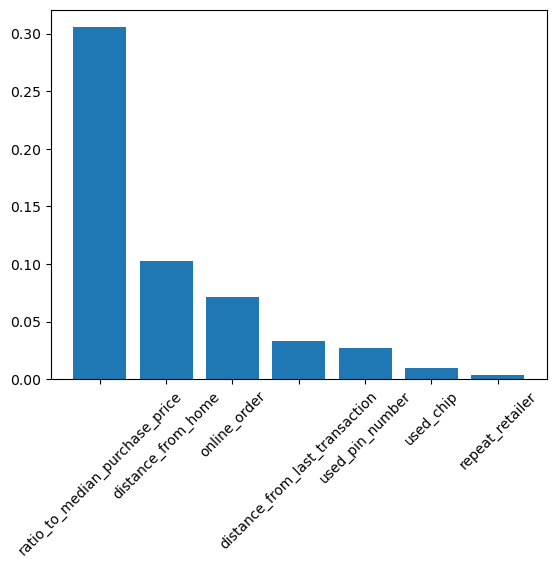

In [99]:
# Calculate permutation feature importance
perm_importancepp3tuned = permutation_importance(model_pp3, X_test3, y_test3, n_repeats=30, random_state=42)

for feature, importance in zip(X_pp3.columns, perm_importancepp3tuned.importances_mean):
    print(f"{feature}: {importance}")

sorted_idx = perm_importancepp3tuned.importances_mean.argsort()[::-1]
plt.bar(range(X_pp3.shape[1]), perm_importancepp3tuned.importances_mean[sorted_idx])
plt.xticks(range(X_pp3.shape[1]), X_pp3.columns[sorted_idx], rotation=45)
plt.show()


In [100]:
feature_importancepp3tuned = pd.DataFrame({'Model': 'Logistic Regression after tuning pp3',
    'Feature': X_pp3.columns,
    'Importance': perm_importancepp3tuned.importances_mean})
feature_importancepp3tuned

,Model,Feature,Importance
0,Logistic Regression after tuning pp3,distance_from_home,0.102553
1,Logistic Regression after tuning pp3,distance_from_last_transaction,0.033714
2,Logistic Regression after tuning pp3,ratio_to_median_purchase_price,0.305437
3,Logistic Regression after tuning pp3,repeat_retailer,0.003719
4,Logistic Regression after tuning pp3,used_chip,0.010181
5,Logistic Regression after tuning pp3,used_pin_number,0.027414
6,Logistic Regression after tuning pp3,online_order,0.071650


In [101]:
#saving the feature importance for pp3 tuned
feature_importancepp3tuned.to_csv('../../data/feature_importancepp3tuned.csv', index=False) 

In [102]:
#saving the models
pickle.dump(lr_pp3, open('models/logistic_regression_pp3_default.pk', 'wb'))  
pickle.dump(model_pp3, open('models/logistic_regression_pp3_tuned.pk', 'wb'))  

## Conclusions

In [103]:
final_results=pd.concat([results_pp1, results_pp2, results_pp3], axis=0)

Adding all the metrics in one dataframe

In [104]:
final_results

,accuracy,precision,recall,f1,kapppa,set,model
0,0.941788,0.935176,0.949384,0.942226,0.883575,test,Logistic Regression pp1
1,0.940429,0.932849,0.949185,0.940946,0.880858,train,Logistic Regression pp1
0,0.941810,0.934005,0.950803,0.942329,0.883621,test,Logistic Regression after tuning pp1
1,0.940429,0.931851,0.950360,0.941015,0.880858,train,Logistic Regression after tuning pp1
0,0.992803,0.988442,0.997266,0.992835,0.985605,test,Logistic Regression pp2
1,0.993088,0.988760,0.997516,0.993119,0.986177,train,Logistic Regression pp2
0,0.941747,0.934455,0.950138,0.942231,0.883493,test,Logistic Regression pp3
1,0.940871,0.933576,0.949283,0.941364,0.881741,train,Logistic Regression pp3
0,0.941804,0.934339,0.950396,0.942299,0.883607,test,Logistic Regression after tuning pp3
1,0.940876,0.933436,0.949459,0.941379,0.881751,train,Logistic Regression after tuning pp3


In [105]:
final_results.to_csv('../../data/final_metrics.csv', index=False)

As we can see above, the model that works the best for this data is Logistic Regression pp2. The best preprocessing was done in pp2 (Removing the outliers , removing column repeat_retailer and upsampling the fraud rows to balance the fraud and non-fraud rows and max_min method to standardize the data). It is important to note that this is only for the context of this project and for the data that I used. The preprocessing and the models depend highly on the data we are dealing with

In [106]:
final_conf_matr=pd.concat([conf_matrix_pp1_df, conf_matrix_pp1_tuned_df, conf_matrix_pp2_df, conf_matrix_pp3_df, conf_matrix_pp3_tuned_df], axis=0)

In [107]:
final_conf_matr

,model,pred_actual,actual,predvsactual,count,prediction
0,Logistic Regression pp1,predicted no fraud,actual no fraud,TN,20413,NaN
1,Logistic Regression pp1,predicted no fraud,actual fraud,FN,1106,NaN
2,Logistic Regression pp1,predicted fraud,actual no fraud,FP,1438,NaN
3,Logistic Regression pp1,predicted fraud,actual fraud,TP,20745,NaN
0,Logistic Regression after tuning pp1,NaN,actual no fraud,TN,20383,predicted no fraud
1,Logistic Regression after tuning pp1,NaN,actual fraud,FN,1079,predicted no fraud
2,Logistic Regression after tuning pp1,NaN,actual no fraud,FP,1468,predicted fraud
3,Logistic Regression after tuning pp1,NaN,actual fraud,TP,20772,predicted fraud
0,Logistic Regression pp2,NaN,actual no fraud,TN,175359,predicted no fraud
1,Logistic Regression pp2,NaN,actual fraud,FN,485,predicted no fraud


In [113]:
#I will remove nulls from prediction and drop column pred_actual
for index, value in final_conf_matr['pred_actual'].iteritems():
    if pd.notna(value):
        final_conf_matr.loc[index, 'prediction'] = value
    else:
        pass


In [115]:
final_conf_matr.drop('pred_actual', axis=1, inplace=True)

In [116]:
final_conf_matr

,model,actual,predvsactual,count,prediction
0,Logistic Regression pp1,actual no fraud,TN,20413,predicted no fraud
1,Logistic Regression pp1,actual fraud,FN,1106,predicted no fraud
2,Logistic Regression pp1,actual no fraud,FP,1438,predicted fraud
3,Logistic Regression pp1,actual fraud,TP,20745,predicted fraud
0,Logistic Regression after tuning pp1,actual no fraud,TN,20383,predicted no fraud
1,Logistic Regression after tuning pp1,actual fraud,FN,1079,predicted no fraud
2,Logistic Regression after tuning pp1,actual no fraud,FP,1468,predicted fraud
3,Logistic Regression after tuning pp1,actual fraud,TP,20772,predicted fraud
0,Logistic Regression pp2,actual no fraud,TN,175359,predicted no fraud
1,Logistic Regression pp2,actual fraud,FN,485,predicted no fraud


In [117]:
final_conf_matr.to_csv('../../data/final_conf_matr.csv', index=False)

In [118]:
final_feat_importance=pd.concat([feature_importancepp1, feature_importancepp1tuned, feature_importancepp2, 
                                feature_importancepp3, feature_importancepp3tuned], axis=0)

In [119]:
final_feat_importance

,Model,Feature,Importance
0,Logistic Regression pp1,distance_from_home,0.103180
1,Logistic Regression pp1,distance_from_last_transaction,0.034195
2,Logistic Regression pp1,ratio_to_median_purchase_price,0.304383
3,Logistic Regression pp1,repeat_retailer,0.004791
4,Logistic Regression pp1,used_chip,0.010167
5,Logistic Regression pp1,used_pin_number,0.027391
6,Logistic Regression pp1,online_order,0.073776
0,Logistic Regression after tuning pp1,distance_from_home,0.103217
1,Logistic Regression after tuning pp1,distance_from_last_transaction,0.033821
2,Logistic Regression after tuning pp1,ratio_to_median_purchase_price,0.307915


In [111]:
final_feat_importance.to_csv('../../data/final_feat_importance.csv', index=False)

Saving the data